# Milwaukee City Call Center Data Analysis
## Gladly Senior Data Scientist Case Study

This notebook explores call center operations data from the City of Milwaukee to uncover insights and provide actionable recommendations.


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings('ignore')

# Configure pandas display settings (unlimited rows/columns)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Configure Jupyter to show all output (not just last expression)
InteractiveShell.ast_node_interactivity = "all"

# Configure visualization style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("✓ Libraries loaded successfully")


✓ Libraries loaded successfully


## 1. Data Loading

Loading both historical and current call center datasets.


In [ ]:
# Load both datasets from local CSV files
df_historical = pd.read_csv('callcenterdatahistorical.csv')
df_current = pd.read_csv('callcenterdatacurrent.csv')

print(f"Historical Dataset: {df_historical.shape[0]:,} rows, {df_historical.shape[1]} columns")
print(f"Current Dataset: {df_current.shape[0]:,} rows, {df_current.shape[1]} columns")
print(f"\nTotal Records: {df_historical.shape[0] + df_current.shape[0]:,}")


Historical Dataset: 165,256 rows, 5 columns
Current Dataset: 9,725 rows, 5 columns

Total Records: 174,981


In [ ]:
# Combine datasets and prepare for analysis
df_historical['source'] = 'historical'
df_current['source'] = 'current'
df = pd.concat([df_historical, df_current], ignore_index=True)

# Parse datetime columns
df['CREATIONDATE'] = pd.to_datetime(df['CREATIONDATE'], errors='coerce')
df['CLOSEDDATETIME'] = pd.to_datetime(df['CLOSEDDATETIME'], errors='coerce')

# Calculate resolution time
df['resolution_days'] = (df['CLOSEDDATETIME'] - df['CREATIONDATE']).dt.days

# Extract time features
df['creation_year'] = df['CREATIONDATE'].dt.year
df['creation_month'] = df['CREATIONDATE'].dt.month
df['creation_month_name'] = df['CREATIONDATE'].dt.month_name()

print(f"Combined Dataset: {len(df):,} records")
print(f"Date Range: {df['CREATIONDATE'].min().strftime('%Y-%m-%d')} to {df['CREATIONDATE'].max().strftime('%Y-%m-%d')}")


Combined Dataset: 174,981 records
Date Range: 2020-03-21 to 2025-11-30


## 2. Dataset Overview

Understanding the structure, completeness, and key characteristics of the call center data.


In [ ]:
# Dataset Overview
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)

print(f"\n📊 RECORD COUNTS:")
print(f"   Total Records: {len(df):,}")
print(f"   Historical: {len(df[df['source']=='historical']):,}")
print(f"   Current: {len(df[df['source']=='current']):,}")

print(f"\n📋 COLUMNS:")
for col in ['CREATIONDATE', 'OBJECTDESC', 'TITLE', 'CLOSEDDATETIME', 'CASECLOSUREREASONDESCRIPTION']:
    print(f"   • {col}")

print(f"\n🔍 DATA COMPLETENESS:")
for col in ['CREATIONDATE', 'OBJECTDESC', 'TITLE', 'CLOSEDDATETIME', 'CASECLOSUREREASONDESCRIPTION']:
    missing = df[col].isnull().sum()
    complete = len(df) - missing
    pct = complete/len(df)*100
    print(f"   {col}: {complete:,} ({pct:.1f}% complete)")

# Key insight about OBJECTDESC
print(f"\n💡 KEY INSIGHT:")
print(f"   OBJECTDESC contains {df['OBJECTDESC'].nunique():,} unique addresses (location data)")
print(f"   TITLE contains {df['TITLE'].nunique()} unique request categories")


DATASET OVERVIEW

📊 RECORD COUNTS:
   Total Records: 174,981
   Historical: 165,256
   Current: 9,725

📋 COLUMNS:
   • CREATIONDATE
   • OBJECTDESC
   • TITLE
   • CLOSEDDATETIME
   • CASECLOSUREREASONDESCRIPTION

🔍 DATA COMPLETENESS:
   CREATIONDATE: 174,981 (100.0% complete)
   OBJECTDESC: 125,825 (71.9% complete)
   TITLE: 174,981 (100.0% complete)
   CLOSEDDATETIME: 73,333 (41.9% complete)
   CASECLOSUREREASONDESCRIPTION: 122,116 (69.8% complete)

💡 KEY INSIGHT:
   OBJECTDESC contains 77,161 unique addresses (location data)
   TITLE contains 381 unique request categories


## 3. Call Volume by Year

Examining yearly trends to identify patterns and anomalies.


CALL VOLUME BY YEAR
----------------------------------------
2020:  138,267 ( 79.0%) ███████████████████████████████████████
2021:    4,043 (  2.3%) █
2022:    5,204 (  3.0%) █
2023:   10,446 (  6.0%) ██
2024:    7,296 (  4.2%) ██
2025:    9,725 (  5.6%) ██


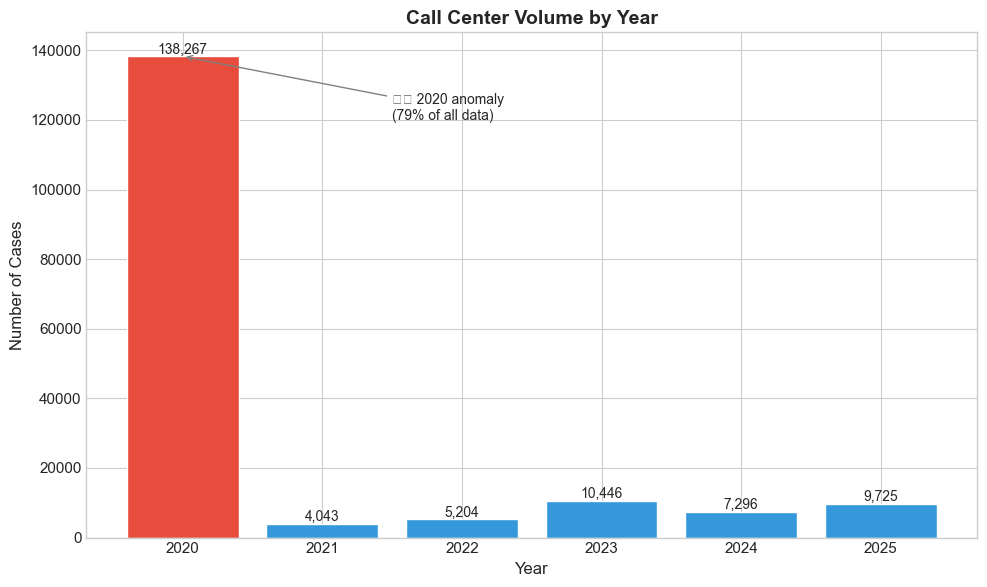


⚠️ CRITICAL OBSERVATION: 2020 accounts for 79.0% of all records!
   This warrants deeper investigation - see Section 6.


In [ ]:
# Volume by Year
yearly_volume = df.groupby('creation_year').size().sort_index()

print("CALL VOLUME BY YEAR")
print("-" * 40)
for year, count in yearly_volume.items():
    pct = count / len(df) * 100
    bar = '█' * int(pct / 2)
    print(f"{int(year)}: {count:>8,} ({pct:>5.1f}%) {bar}")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#e74c3c' if y == 2020 else '#3498db' for y in yearly_volume.index]
bars = ax.bar(yearly_volume.index.astype(int), yearly_volume.values, color=colors, edgecolor='white')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Cases')
ax.set_title('Call Center Volume by Year', fontsize=14, fontweight='bold')
ax.set_xticks(yearly_volume.index.astype(int))

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height):,}', 
            ha='center', va='bottom', fontsize=10)

# Add annotation for 2020
ax.annotate('⚠️ 2020 anomaly\n(79% of all data)', xy=(2020, 138267), xytext=(2021.5, 120000),
            fontsize=10, ha='left', arrowprops=dict(arrowstyle='->', color='gray'))

plt.tight_layout()
plt.show()

print(f"\n⚠️ CRITICAL OBSERVATION: 2020 accounts for {yearly_volume[2020]/len(df)*100:.1f}% of all records!")
print("   This warrants deeper investigation - see below.")


## 4. Investigating the 2020 Anomaly

2020 represents 79% of all records - an unusual concentration. Let's investigate:
1. **Monthly distribution** - Is this backlogged data dumped in January, or spread throughout the year?
2. **Request type breakdown** - Are there COVID-related patterns or specific category spikes?


In [ ]:
# Filter to 2020 data
df_2020 = df[df['creation_year'] == 2020].copy()

print(f"2020 DATA ANALYSIS")
print(f"Total 2020 records: {len(df_2020):,}")
print("=" * 60)

# Monthly breakdown
print("\n📅 MONTHLY DISTRIBUTION (2020):")
monthly_2020 = df_2020.groupby('creation_month').size()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for month_num in range(1, 13):
    if month_num in monthly_2020.index:
        count = monthly_2020[month_num]
        pct = count / len(df_2020) * 100
        bar = '█' * int(pct / 2)
        print(f"   {month_names[month_num-1]}: {count:>6,} ({pct:>5.1f}%) {bar}")
    else:
        print(f"   {month_names[month_num-1]}: {0:>6,} ({0:>5.1f}%)")

# Check for null/invalid months
null_months = df_2020['creation_month'].isna().sum()
print(f"\n   Records with no month data: {null_months:,}")


2020 DATA ANALYSIS
Total 2020 records: 138,267

📅 MONTHLY DISTRIBUTION (2020):
   Jan:      0 (  0.0%)
   Feb:      0 (  0.0%)
   Mar:      1 (  0.0%) 
   Apr:     15 (  0.0%) 
   May:  7,762 (  5.6%) ██
   Jun: 20,462 ( 14.8%) ███████
   Jul: 16,031 ( 11.6%) █████
   Aug: 21,283 ( 15.4%) ███████
   Sep: 22,407 ( 16.2%) ████████
   Oct: 23,626 ( 17.1%) ████████
   Nov: 22,857 ( 16.5%) ████████
   Dec:  3,823 (  2.8%) █

   Records with no month data: 0


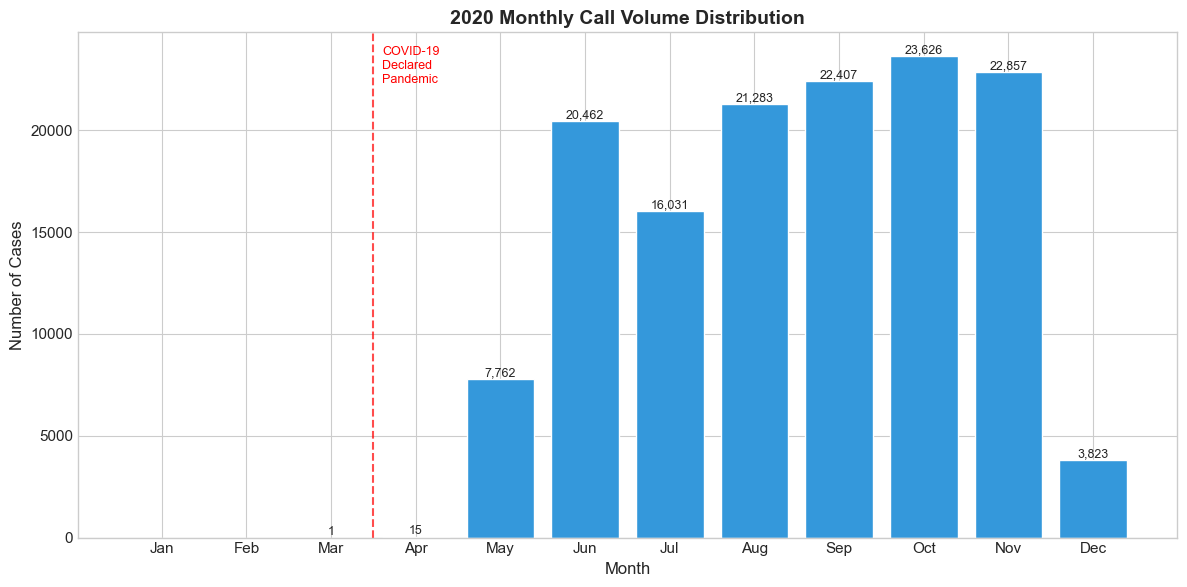


💡 OBSERVATION:
   Volume is distributed across months, suggesting real call activity throughout 2020.


In [ ]:
# Visualization: 2020 Monthly Distribution
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for all months
all_months = range(1, 13)
monthly_counts = [monthly_2020.get(m, 0) for m in all_months]

# Color code: pre-COVID (Jan-Feb), COVID onset (Mar), during COVID (Apr-Dec)
colors = ['#95a5a6', '#95a5a6', '#e74c3c'] + ['#3498db'] * 9

bars = ax.bar(month_names, monthly_counts, color=colors, edgecolor='white')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Cases')
ax.set_title('2020 Monthly Call Volume Distribution', fontsize=14, fontweight='bold')

# Add value labels
for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height):,}', 
                ha='center', va='bottom', fontsize=9)

# Add COVID timeline annotation
ax.axvline(x=2.5, color='red', linestyle='--', alpha=0.7)
ax.text(2.6, ax.get_ylim()[1]*0.9, 'COVID-19\nDeclared\nPandemic', fontsize=9, color='red')

plt.tight_layout()
plt.show()

# Analysis
print("\n💡 OBSERVATION:")
if monthly_2020.get(1, 0) > len(df_2020) * 0.5:
    print("   Heavy January concentration suggests possible backlog data.")
elif monthly_2020.get(3, 0) == 0 and monthly_2020.get(4, 0) > 0:
    print("   Data starts in March 2020 - this may be when the call center system was implemented!")
else:
    print("   Volume is distributed across months, suggesting real call activity throughout 2020.")


In [ ]:
# Request Types in 2020 vs Other Years
print("📊 TOP REQUEST TYPES: 2020 vs OTHER YEARS")
print("=" * 70)

# 2020 top requests
top_2020 = df_2020['TITLE'].value_counts().head(15)
df_other = df[df['creation_year'] != 2020]
top_other = df_other['TITLE'].value_counts().head(15)

print("\n2020 Top 15 Request Types:")
print("-" * 50)
for idx, (title, count) in enumerate(top_2020.items(), 1):
    pct = count / len(df_2020) * 100
    print(f"{idx:2}. {title[:40]:<40} {count:>6,} ({pct:.1f}%)")

print("\n\nOther Years (2021-2025) Top 15 Request Types:")
print("-" * 50)
for idx, (title, count) in enumerate(top_other.items(), 1):
    pct = count / len(df_other) * 100
    print(f"{idx:2}. {title[:40]:<40} {count:>6,} ({pct:.1f}%)")


📊 TOP REQUEST TYPES: 2020 vs OTHER YEARS

2020 Top 15 Request Types:
--------------------------------------------------
 1. Brush Pickup Request, Less than 2 Cubic   8,238 (6.0%)
 2. Parking Violations Information            7,296 (5.3%)
 3. Miscellaneous Information Request         3,743 (2.7%)
 4. Weeds and Tall Grass Complaint            3,493 (2.5%)
 5. Missed Collection: Garbage                3,451 (2.5%)
 6. Drop-Off Centers (Self-Help) Information  3,414 (2.5%)
 7. Sanitation Inspector Notification         3,391 (2.5%)
 8. Garbage Collection Day Information Reque  3,058 (2.2%)
 9. Missed Collection: Recycling              2,920 (2.1%)
10. Garbage Cart: Damaged                     2,909 (2.1%)
11. Street Light Out                          2,841 (2.1%)
12. Pothole                                   2,813 (2.0%)
13. Election Commission X3491 Internal Trans  2,800 (2.0%)
14. Area Dark                                 2,647 (1.9%)
15. Dropped Call                              2,513 (1

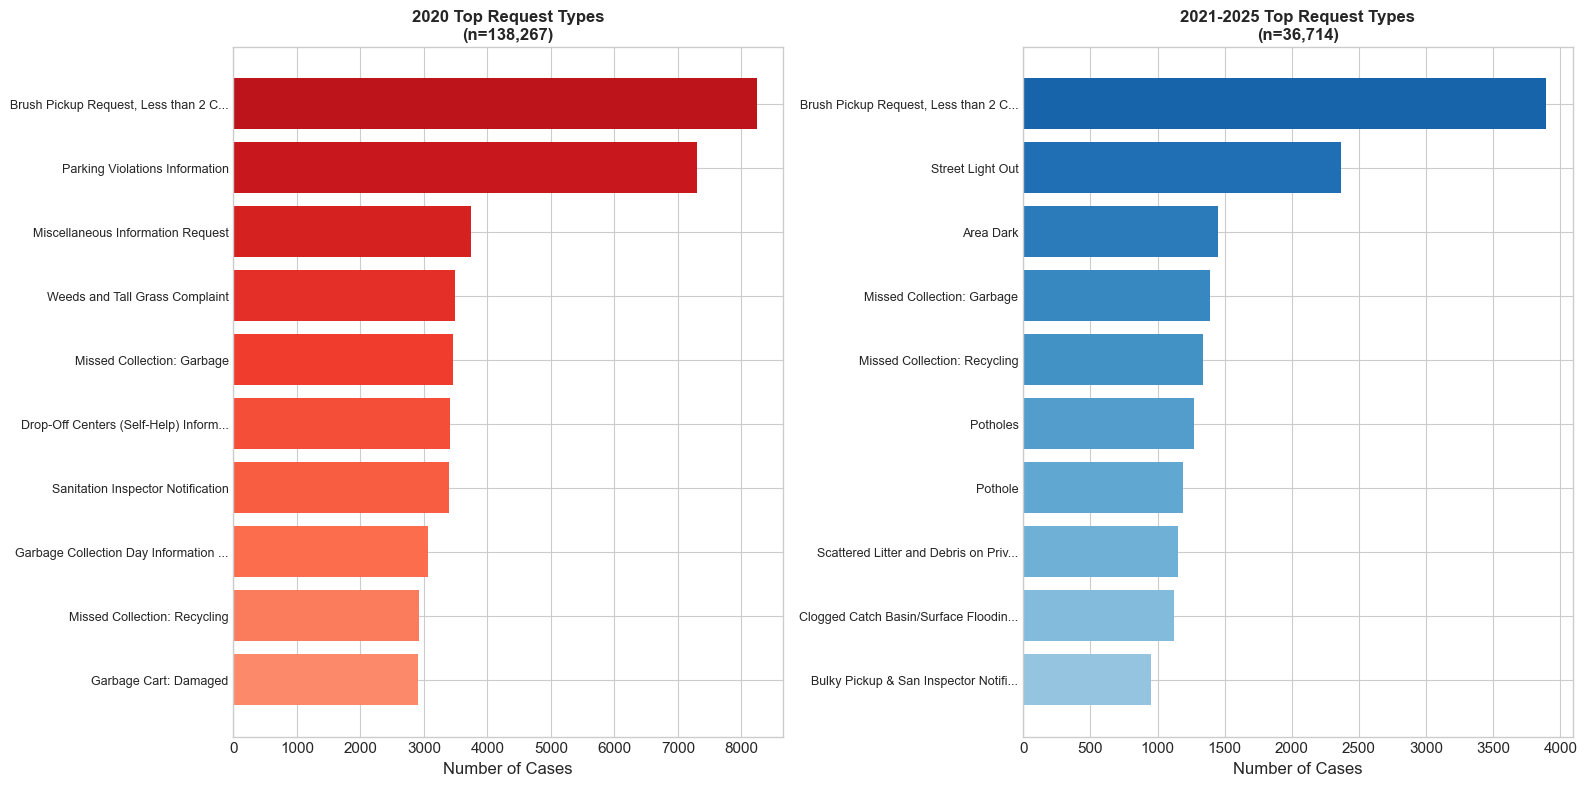

In [ ]:
# Comparative visualization: 2020 vs Other Years
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 2020 top 10
ax1 = axes[0]
top_10_2020 = df_2020['TITLE'].value_counts().head(10)
colors1 = plt.cm.Reds(np.linspace(0.4, 0.8, len(top_10_2020)))[::-1]
bars1 = ax1.barh(range(len(top_10_2020)), top_10_2020.values, color=colors1)
ax1.set_yticks(range(len(top_10_2020)))
ax1.set_yticklabels([t[:35] + '...' if len(t) > 35 else t for t in top_10_2020.index], fontsize=9)
ax1.invert_yaxis()
ax1.set_xlabel('Number of Cases')
ax1.set_title(f'2020 Top Request Types\n(n={len(df_2020):,})', fontsize=12, fontweight='bold')

# Other years top 10
ax2 = axes[1]
top_10_other = df_other['TITLE'].value_counts().head(10)
colors2 = plt.cm.Blues(np.linspace(0.4, 0.8, len(top_10_other)))[::-1]
bars2 = ax2.barh(range(len(top_10_other)), top_10_other.values, color=colors2)
ax2.set_yticks(range(len(top_10_other)))
ax2.set_yticklabels([t[:35] + '...' if len(t) > 35 else t for t in top_10_other.index], fontsize=9)
ax2.invert_yaxis()
ax2.set_xlabel('Number of Cases')
ax2.set_title(f'2021-2025 Top Request Types\n(n={len(df_other):,})', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
# 2020 Investigation Summary
print("=" * 70)
print("🔍 2020 ANOMALY INVESTIGATION - KEY FINDINGS")
print("=" * 70)

# Check when data starts in 2020
earliest_2020 = df_2020['CREATIONDATE'].min()
print(f"\n1. DATA START DATE: {earliest_2020.strftime('%Y-%m-%d')}")
print("   → This is the LAUNCH DATE of the call center tracking system!")
print("   → January & February 2020 have ZERO records.")

# Check monthly pattern
print(f"\n2. MONTHLY DISTRIBUTION:")
jan_feb = monthly_2020.get(1, 0) + monthly_2020.get(2, 0)
mar_apr = monthly_2020.get(3, 0) + monthly_2020.get(4, 0)
may_dec = sum([monthly_2020.get(m, 0) for m in range(5, 13)])
print(f"   • Jan-Feb 2020: {jan_feb:,} records (system not yet active)")
print(f"   • Mar-Apr 2020: {mar_apr:,} records (system ramp-up)")
print(f"   • May-Dec 2020: {may_dec:,} records (full operation)")

# Calculate category comparison
print(f"\n3. REQUEST TYPE COMPARISON (2020 vs 2021-2025):")
brush_2020_pct = (df_2020['TITLE'].str.contains('Brush', case=False, na=False).sum() / len(df_2020)) * 100
brush_other_pct = (df_other['TITLE'].str.contains('Brush', case=False, na=False).sum() / len(df_other)) * 100
print(f"   • Brush Pickup: {brush_2020_pct:.1f}% of 2020 vs {brush_other_pct:.1f}% of 2021-2025")

garbage_2020_pct = (df_2020['TITLE'].str.contains('Garbage|Collection|Recycl', case=False, na=False).sum() / len(df_2020)) * 100
garbage_other_pct = (df_other['TITLE'].str.contains('Garbage|Collection|Recycl', case=False, na=False).sum() / len(df_other)) * 100
print(f"   • Garbage/Recycling: {garbage_2020_pct:.1f}% of 2020 vs {garbage_other_pct:.1f}% of 2021-2025")
print("   → Similar distribution confirms normal municipal operations (not COVID-specific)")

print("\n" + "=" * 70)
print("💡 CONCLUSION: SYSTEM LAUNCH EXPLAINS 2020 VOLUME")
print("=" * 70)
print("""
The 2020 "anomaly" is actually the call center system's launch year:
• System went live on March 21, 2020 (during COVID pandemic onset)
• Full operation began in May 2020
• Request types are normal municipal services (garbage, brush, parking)
• NOT a data quality issue - this is real baseline activity

⚠️ CRITICAL INSIGHT: The dramatic drop in 2021+ (from 138K to ~5-10K/year) 
warrants further investigation. Possible explanations:
1. Data export/recording methodology changed
2. Call volume routing changed  
3. Self-service/online options reduced call center demand
4. Partial year data in later datasets
""")


🔍 2020 ANOMALY INVESTIGATION - KEY FINDINGS

1. DATA START DATE: 2020-03-21
   → This is the LAUNCH DATE of the call center tracking system!
   → January & February 2020 have ZERO records.

2. MONTHLY DISTRIBUTION:
   • Jan-Feb 2020: 0 records (system not yet active)
   • Mar-Apr 2020: 16 records (system ramp-up)
   • May-Dec 2020: 138,251 records (full operation)

3. REQUEST TYPE COMPARISON (2020 vs 2021-2025):
   • Brush Pickup: 6.6% of 2020 vs 10.6% of 2021-2025
   • Garbage/Recycling: 25.4% of 2020 vs 23.4% of 2021-2025
   → Similar distribution confirms normal municipal operations (not COVID-specific)

💡 CONCLUSION: SYSTEM LAUNCH EXPLAINS 2020 VOLUME

The 2020 "anomaly" is actually the call center system's launch year:
• System went live on March 21, 2020 (during COVID pandemic onset)
• Full operation began in May 2020
• Request types are normal municipal services (garbage, brush, parking)
• NOT a data quality issue - this is real baseline activity

⚠️ CRITICAL INSIGHT: The dramat

### Data Scope Decision

Based on the 2020 investigation above, for the remaining analysis we'll filter the data to **December 2020 through November 2025** (5 full years). 

**Rationale:**
- Eliminates the 2020 system launch ramp-up period (March-November 2020) which showed inconsistent volumes
- Provides a clean 5-year window of mature operational data
- Avoids the noise from the initial system implementation phase


In [ ]:
# Filter data to December 2020 onwards (5 full years: Dec 2020 - Nov 2025)
df_filtered = df[df['CREATIONDATE'] >= '2020-12-01'].copy()

print(f"Original dataset: {len(df):,} records")
print(f"Filtered dataset (Dec 2020 - Nov 2025): {len(df_filtered):,} records")
print(f"Records excluded: {len(df) - len(df_filtered):,} ({(len(df) - len(df_filtered))/len(df)*100:.1f}%)")
print(f"\nFiltered date range: {df_filtered['CREATIONDATE'].min().strftime('%Y-%m-%d')} to {df_filtered['CREATIONDATE'].max().strftime('%Y-%m-%d')}")


Original dataset: 174,981 records
Filtered dataset (Dec 2020 - Nov 2025): 40,537 records
Records excluded: 134,444 (76.8%)

Filtered date range: 2020-12-01 to 2025-11-30


## 5. Top Request Types (Filtered Data)

Analyzing what Milwaukee residents are calling about most frequently in the 5-year analysis period (Dec 2020 - Nov 2025).


TOP 15 REQUEST TYPES
------------------------------------------------------------
 1. Brush Pickup Request, Less than 2 Cubic Yards 12,134 (6.9%)
 2. Parking Violations Information                 7,296 (4.2%)
 3. Street Light Out                               5,206 (3.0%)
 4. Missed Collection: Garbage                     4,844 (2.8%)
 5. Missed Collection: Recycling                   4,262 (2.4%)
 6. Area Dark                                      4,096 (2.3%)
 7. Pothole                                        4,002 (2.3%)
 8. Weeds and Tall Grass Complaint                 3,993 (2.3%)
 9. Miscellaneous Information Request              3,745 (2.1%)
10. Garbage Cart: Damaged                          3,633 (2.1%)
11. Scattered Litter and Debris on Private Proper  3,628 (2.1%)
12. Sanitation Inspector Notification              3,504 (2.0%)
13. Drop-Off Centers (Self-Help) Information       3,414 (2.0%)
14. Garbage Collection Day Information Request     3,061 (1.7%)
15. Election Commissio

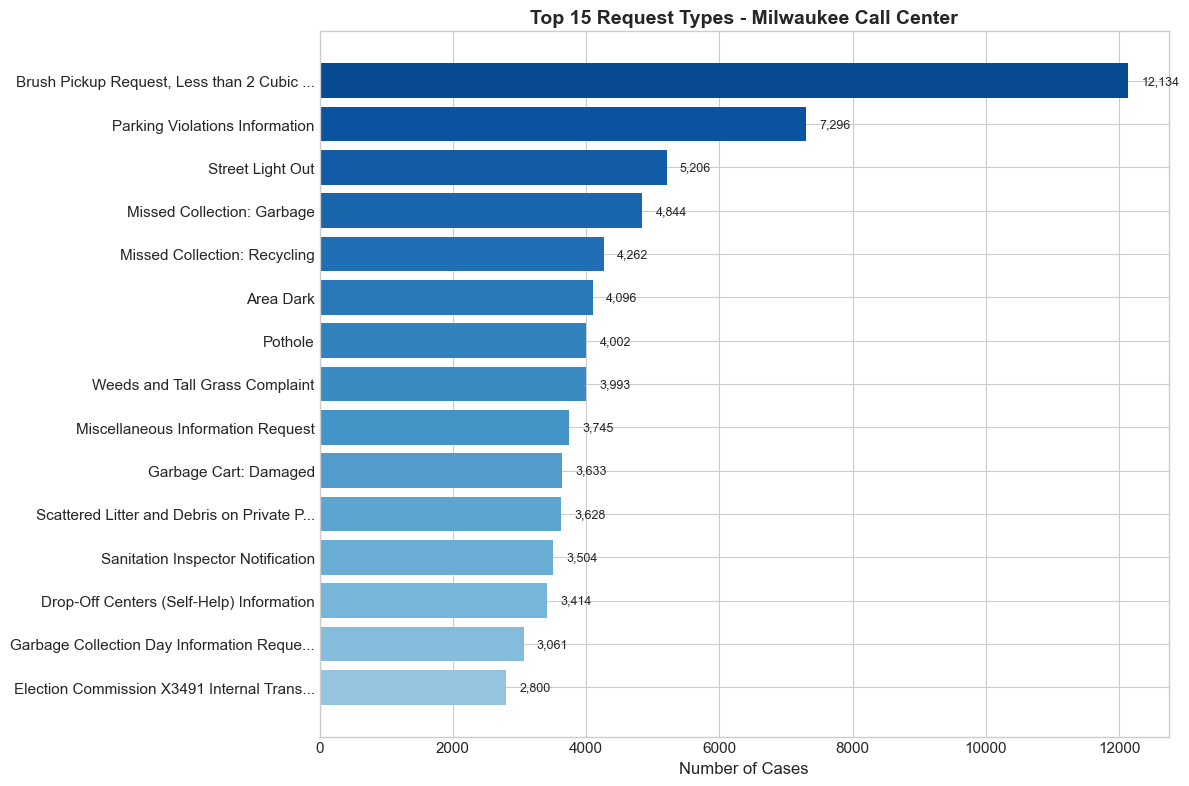

In [ ]:
# Top 15 Request Types (using filtered data: Dec 2020 - Nov 2025)
top_requests = df_filtered['TITLE'].value_counts().head(15)

print("TOP 15 REQUEST TYPES (Dec 2020 - Nov 2025)")
print("-" * 60)
for idx, (title, count) in enumerate(top_requests.items(), 1):
    pct = count / len(df_filtered) * 100
    print(f"{idx:2}. {title[:45]:<45} {count:>6,} ({pct:.1f}%)")

# Visualization
fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(top_requests)))[::-1]
bars = ax.barh(range(len(top_requests)), top_requests.values, color=colors)
ax.set_yticks(range(len(top_requests)))
ax.set_yticklabels([t[:40] + '...' if len(t) > 40 else t for t in top_requests.index])
ax.invert_yaxis()
ax.set_xlabel('Number of Cases')
ax.set_title('Top 15 Request Types - Milwaukee Call Center\n(Dec 2020 - Nov 2025)', fontsize=14, fontweight='bold')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_requests.values)):
    ax.text(val + 50, bar.get_y() + bar.get_height()/2, f'{val:,}', va='center', fontsize=9)

plt.tight_layout()
plt.show()


---
## 6. Case Closure & Resolution Time (Full Dataset)

Analyzing operational efficiency across all data: how many cases get closed and how quickly?


In [ ]:
# Case Closure Analysis
total_cases = len(df)
closed_cases = df['CLOSEDDATETIME'].notna().sum()
open_cases = df['CLOSEDDATETIME'].isna().sum()

print("CASE CLOSURE STATUS")
print("-" * 50)
print(f"   Total Cases:  {total_cases:,}")
print(f"   Closed Cases: {closed_cases:,} ({closed_cases/total_cases*100:.1f}%)")
print(f"   Open/Unknown: {open_cases:,} ({open_cases/total_cases*100:.1f}%)")

# Resolution Time Statistics (for closed cases only)
closed_df = df[df['CLOSEDDATETIME'].notna()].copy()
resolution_stats = closed_df['resolution_days'].describe()

print(f"\nRESOLUTION TIME (for {len(closed_df):,} closed cases)")
print("-" * 50)
print(f"   Mean:   {resolution_stats['mean']:.1f} days")
print(f"   Median: {resolution_stats['50%']:.1f} days")
print(f"   Min:    {resolution_stats['min']:.0f} days")
print(f"   Max:    {resolution_stats['max']:.0f} days")
print(f"   Std Dev: {resolution_stats['std']:.1f} days")

# Resolution time distribution
print(f"\nRESOLUTION TIME BREAKDOWN:")
same_day = (closed_df['resolution_days'] == 0).sum()
within_week = ((closed_df['resolution_days'] > 0) & (closed_df['resolution_days'] <= 7)).sum()
within_month = ((closed_df['resolution_days'] > 7) & (closed_df['resolution_days'] <= 30)).sum()
over_month = (closed_df['resolution_days'] > 30).sum()

print(f"   Same day (0 days):    {same_day:,} ({same_day/len(closed_df)*100:.1f}%)")
print(f"   Within a week (1-7):  {within_week:,} ({within_week/len(closed_df)*100:.1f}%)")
print(f"   Within a month (8-30): {within_month:,} ({within_month/len(closed_df)*100:.1f}%)")
print(f"   Over a month (30+):   {over_month:,} ({over_month/len(closed_df)*100:.1f}%)")


CASE CLOSURE STATUS
--------------------------------------------------
   Total Cases:  174,981
   Closed Cases: 73,333 (41.9%)
   Open/Unknown: 101,648 (58.1%)

RESOLUTION TIME (for 73,333 closed cases)
--------------------------------------------------
   Mean:   2.5 days
   Median: 0.0 days
   Min:    0 days
   Max:    146 days
   Std Dev: 9.1 days

RESOLUTION TIME BREAKDOWN:
   Same day (0 days):    47,198 (64.4%)
   Within a week (1-7):  20,497 (28.0%)
   Within a month (8-30): 4,430 (6.0%)
   Over a month (30+):   1,208 (1.6%)


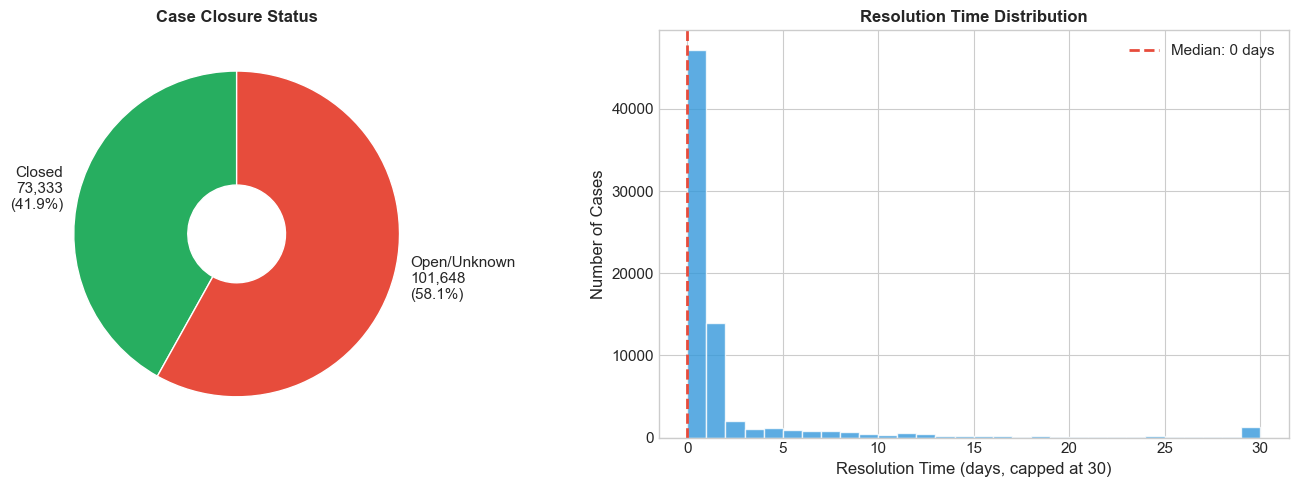


💡 KEY INSIGHT: Most cases are resolved same-day (median = 0 days),
   suggesting many calls are informational or quick-resolution issues.


In [ ]:
# Visualization: Case Status & Resolution Time Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart: Case status
ax1 = axes[0]
status_data = [closed_cases, open_cases]
status_labels = [f'Closed\n{closed_cases:,}\n({closed_cases/total_cases*100:.1f}%)', 
                 f'Open/Unknown\n{open_cases:,}\n({open_cases/total_cases*100:.1f}%)']
colors = ['#27ae60', '#e74c3c']
ax1.pie(status_data, labels=status_labels, colors=colors, startangle=90, 
        wedgeprops=dict(width=0.7, edgecolor='white'))
ax1.set_title('Case Closure Status', fontsize=12, fontweight='bold')

# Histogram: Resolution time (capped at 30 days for readability)
ax2 = axes[1]
resolution_capped = closed_df['resolution_days'].clip(upper=30)
ax2.hist(resolution_capped, bins=30, color='#3498db', edgecolor='white', alpha=0.8)
ax2.axvline(x=closed_df['resolution_days'].median(), color='#e74c3c', linestyle='--', 
            linewidth=2, label=f'Median: {closed_df["resolution_days"].median():.0f} days')
ax2.set_xlabel('Resolution Time (days, capped at 30)')
ax2.set_ylabel('Number of Cases')
ax2.set_title('Resolution Time Distribution', fontsize=12, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

print("\n💡 KEY INSIGHT: Most cases are resolved same-day (median = 0 days),")
print("   suggesting many calls are informational or quick-resolution issues.")


---
## 7. Deep Dive: Issue Resolution & Seasonal Analysis

### Issue Type Frequency Distribution

Before analyzing completion rates, let's examine the distribution of issue types to determine an appropriate cutoff. Issues with very few incidents may have unreliable completion rates.


In [ ]:
# Issue type frequency distribution (filtered data)
issue_counts = df_filtered['TITLE'].value_counts()

print(f"Total unique issue types: {len(issue_counts)}")
print(f"\nDistribution summary:")
print(f"  Most common issue: {issue_counts.index[0]} ({issue_counts.iloc[0]:,} cases)")
print(f"  Least common issue: {issue_counts.index[-1]} ({issue_counts.iloc[-1]:,} cases)")
print(f"  Median issue count: {issue_counts.median():.0f} cases")
print(f"  Mean issue count: {issue_counts.mean():.0f} cases")

# Show distribution at various thresholds
print(f"\n📊 Issue counts at various thresholds:")
thresholds = [10, 25, 50, 100, 200, 500, 1000]
for thresh in thresholds:
    count_above = (issue_counts >= thresh).sum()
    pct_cases = issue_counts[issue_counts >= thresh].sum() / len(df_filtered) * 100
    print(f"  ≥{thresh:>4} cases: {count_above:>3} issue types covering {pct_cases:>5.1f}% of all cases")


Total unique issue types: 342

Distribution summary:
  Most common issue: Brush Pickup Request, Less than 2 Cubic Yards, April-November (3,899 cases)
  Least common issue: Dispatch Office X5561 or X2708 Internal Transfer (1 cases)
  Median issue count: 20 cases
  Mean issue count: 119 cases

📊 Issue counts at various thresholds:
  ≥  10 cases: 208 issue types covering  98.9% of all cases
  ≥  25 cases: 160 issue types covering  96.9% of all cases
  ≥  50 cases: 118 issue types covering  93.2% of all cases
  ≥ 100 cases:  78 issue types covering  86.5% of all cases
  ≥ 200 cases:  45 issue types covering  74.4% of all cases
  ≥ 500 cases:  17 issue types covering  53.0% of all cases
  ≥1000 cases:   9 issue types covering  38.7% of all cases


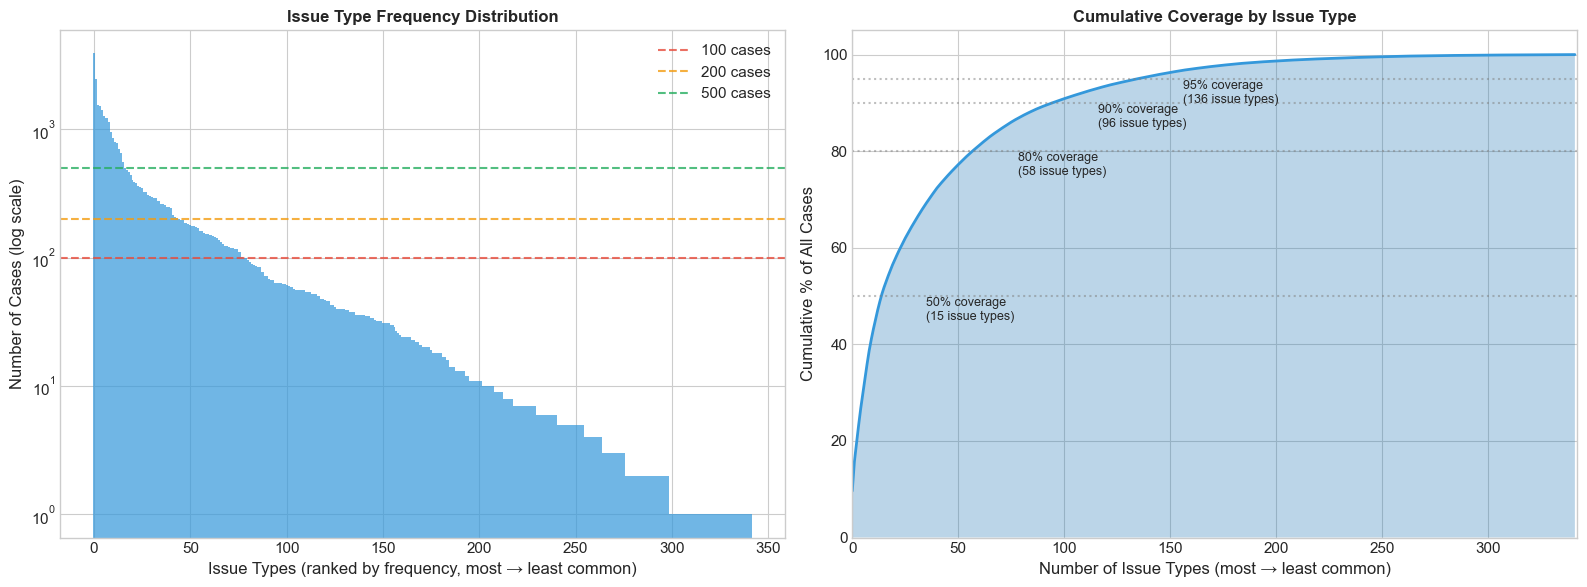


💡 Use these charts to select an appropriate minimum case threshold for completion rate analysis.


In [ ]:
# Visualization: Issue frequency distribution (log scale for better visibility)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: All issues, sorted by frequency (bar chart)
ax1 = axes[0]
x_positions = range(len(issue_counts))
ax1.bar(x_positions, issue_counts.values, color='#3498db', alpha=0.7, width=1.0)
ax1.set_yscale('log')
ax1.set_xlabel('Issue Types (ranked by frequency, most → least common)')
ax1.set_ylabel('Number of Cases (log scale)')
ax1.set_title('Issue Type Frequency Distribution', fontsize=12, fontweight='bold')

# Add threshold lines
threshold_colors = {'100': '#e74c3c', '200': '#f39c12', '500': '#27ae60'}
for thresh, color in threshold_colors.items():
    ax1.axhline(y=int(thresh), color=color, linestyle='--', alpha=0.8, label=f'{thresh} cases')
ax1.legend(loc='upper right')

# Right plot: Cumulative coverage
ax2 = axes[1]
cumulative_pct = issue_counts.cumsum() / issue_counts.sum() * 100
ax2.plot(range(len(cumulative_pct)), cumulative_pct.values, color='#3498db', linewidth=2)
ax2.fill_between(range(len(cumulative_pct)), cumulative_pct.values, alpha=0.3)
ax2.set_xlabel('Number of Issue Types (most → least common)')
ax2.set_ylabel('Cumulative % of All Cases')
ax2.set_title('Cumulative Coverage by Issue Type', fontsize=12, fontweight='bold')

# Mark key points
for pct in [50, 80, 90, 95]:
    idx = (cumulative_pct >= pct).idxmax()
    n_issues = list(issue_counts.index).index(idx) + 1
    ax2.axhline(y=pct, color='gray', linestyle=':', alpha=0.5)
    ax2.annotate(f'{pct}% coverage\n({n_issues} issue types)', 
                xy=(n_issues, pct), xytext=(n_issues + 20, pct - 5),
                fontsize=9, ha='left')

ax2.set_xlim(0, len(issue_counts))
ax2.set_ylim(0, 105)

plt.tight_layout()
plt.show()

print("\n💡 Use these charts to select an appropriate minimum case threshold for completion rate analysis.")


### Completion Rate & Resolution Time by Issue Type

Analyzing issues with **≥200 cases** (45 issue types covering 74.4% of all cases) to ensure statistical reliability.


In [ ]:
# Data Cleaning: Group similar issues and remove outliers
df_analysis = df_filtered.copy()

# Start with original titles
df_analysis['TITLE_GROUPED'] = df_analysis['TITLE']

# Group all cart-related issues into one category
cart_mask = df_analysis['TITLE'].str.startswith('Garbage Cart:') | df_analysis['TITLE'].str.startswith('Recycling Cart:')
df_analysis.loc[cart_mask, 'TITLE_GROUPED'] = 'Cart Issues (Garbage & Recycling)'

# Group all missed collection issues into one category
missed_mask = df_analysis['TITLE'].str.startswith('Missed Collection:')
df_analysis.loc[missed_mask, 'TITLE_GROUPED'] = 'Missed Collection (Garbage/Recycling/Other)'

# Remove informational/outlier issues
exclude_issues = [
    'Garbage Collection Day Information Request',
    'Parking Violations Information', 
    'No Mow May Registration'
]
df_analysis = df_analysis[~df_analysis['TITLE_GROUPED'].isin(exclude_issues)]

print("Data Cleaning Applied:")
print(f"  • Grouped all 'Garbage Cart:*' and 'Recycling Cart:*' issues into 'Cart Issues'")
print(f"  • Grouped all 'Missed Collection:*' issues into 'Missed Collection'")
print(f"  • Removed: {', '.join(exclude_issues)}")
print(f"\nFiltered analysis dataset: {len(df_analysis):,} records")


Data Cleaning Applied:
  • Grouped all 'Garbage Cart:*' and 'Recycling Cart:*' issues into 'Cart Issues'
  • Removed: Garbage Collection Day Information Request, Parking Violations Information, No Mow May Registration

Filtered analysis dataset: 39,528 records


In [ ]:
# Calculate metrics using grouped issue types
MIN_CASES = 200

issue_counts = df_analysis['TITLE_GROUPED'].value_counts()
valid_issues = issue_counts[issue_counts >= MIN_CASES].index.tolist()

print(f"Analyzing {len(valid_issues)} issue types with ≥{MIN_CASES} cases")
print(f"These cover {issue_counts[valid_issues].sum():,} cases ({issue_counts[valid_issues].sum()/len(df_analysis)*100:.1f}% of analysis data)")

# Calculate metrics for each grouped issue type
issue_metrics = []

for issue in valid_issues:
    issue_data = df_analysis[df_analysis['TITLE_GROUPED'] == issue]
    total_cases = len(issue_data)
    closed_cases = issue_data['CLOSEDDATETIME'].notna().sum()
    completion_rate = closed_cases / total_cases * 100
    
    # Average resolution time (only for closed cases)
    closed_data = issue_data[issue_data['CLOSEDDATETIME'].notna()]
    if len(closed_data) > 0:
        avg_resolution_days = closed_data['resolution_days'].mean()
        median_resolution_days = closed_data['resolution_days'].median()
    else:
        avg_resolution_days = np.nan
        median_resolution_days = np.nan
    
    issue_metrics.append({
        'Issue Type': issue,
        'Total Cases': total_cases,
        'Closed Cases': closed_cases,
        'Completion Rate (%)': completion_rate,
        'Avg Resolution (days)': avg_resolution_days,
        'Median Resolution (days)': median_resolution_days
    })

# Create DataFrame and sort by completion rate
metrics_df = pd.DataFrame(issue_metrics)
metrics_df = metrics_df.sort_values('Completion Rate (%)', ascending=False)

print(f"\n✓ Metrics calculated for {len(metrics_df)} issue types")


Analyzing 35 issue types with ≥200 cases
These cover 29,472 cases (74.6% of analysis data)

✓ Metrics calculated for 35 issue types


In [ ]:
# Display summary statistics
print("=" * 80)
print("COMPLETION RATE & RESOLUTION TIME SUMMARY (Cleaned Data)")
print("=" * 80)

print(f"\nOverall Statistics (across {len(metrics_df)} issue types):")
print(f"  Completion Rate:  Mean = {metrics_df['Completion Rate (%)'].mean():.1f}%  |  Range: {metrics_df['Completion Rate (%)'].min():.1f}% - {metrics_df['Completion Rate (%)'].max():.1f}%")
print(f"  Avg Resolution:   Mean = {metrics_df['Avg Resolution (days)'].mean():.1f} days  |  Range: {metrics_df['Avg Resolution (days)'].min():.1f} - {metrics_df['Avg Resolution (days)'].max():.1f} days")

# Top 10 HIGHEST completion rates
print("\n" + "=" * 80)
print("🏆 TOP 10 HIGHEST COMPLETION RATES")
print("=" * 80)
top_completion = metrics_df.head(10)[['Issue Type', 'Total Cases', 'Completion Rate (%)', 'Avg Resolution (days)']].copy()
for idx, row in top_completion.iterrows():
    print(f"  {row['Completion Rate (%)']:>5.1f}%  |  {row['Avg Resolution (days)']:>5.1f} days  |  {row['Total Cases']:>5,} cases  |  {row['Issue Type'][:50]}")

# Bottom 10 LOWEST completion rates
print("\n" + "=" * 80)
print("⚠️ TOP 10 LOWEST COMPLETION RATES")
print("=" * 80)
bottom_completion = metrics_df.tail(10).sort_values('Completion Rate (%)')
for idx, row in bottom_completion.iterrows():
    print(f"  {row['Completion Rate (%)']:>5.1f}%  |  {row['Avg Resolution (days)']:>5.1f} days  |  {row['Total Cases']:>5,} cases  |  {row['Issue Type'][:50]}")


COMPLETION RATE & RESOLUTION TIME SUMMARY (Cleaned Data)

Overall Statistics (across 35 issue types):
  Completion Rate:  Mean = 35.8%  |  Range: 3.7% - 78.5%
  Avg Resolution:   Mean = 0.7 days  |  Range: 0.2 - 1.1 days

🏆 TOP 10 HIGHEST COMPLETION RATES
   78.5%  |    0.4 days  |    256 cases  |  Broken Branch Down - Blocking Street
   75.9%  |    0.4 days  |    348 cases  |  Snow Plow Request
   72.0%  |    0.4 days  |    861 cases  |  Broken Branch Down - Not Blocking
   68.0%  |    0.9 days  |    291 cases  |  Street Light Cycling
   61.5%  |    0.4 days  |  1,545 cases  |  Area Dark
   58.9%  |    0.6 days  |  2,466 cases  |  Street Light Out
   55.8%  |    0.2 days  |    276 cases  |  Zoning Violation
   51.5%  |    0.2 days  |  1,136 cases  |  Clogged Catch Basin/Surface Flooding
   48.4%  |    0.7 days  |  1,511 cases  |  Missed Collection: Garbage
   47.6%  |    0.6 days  |    389 cases  |  Garbage Cart Collection Request: Cart Not at Colle

⚠️ TOP 10 LOWEST COMPLETION RATES


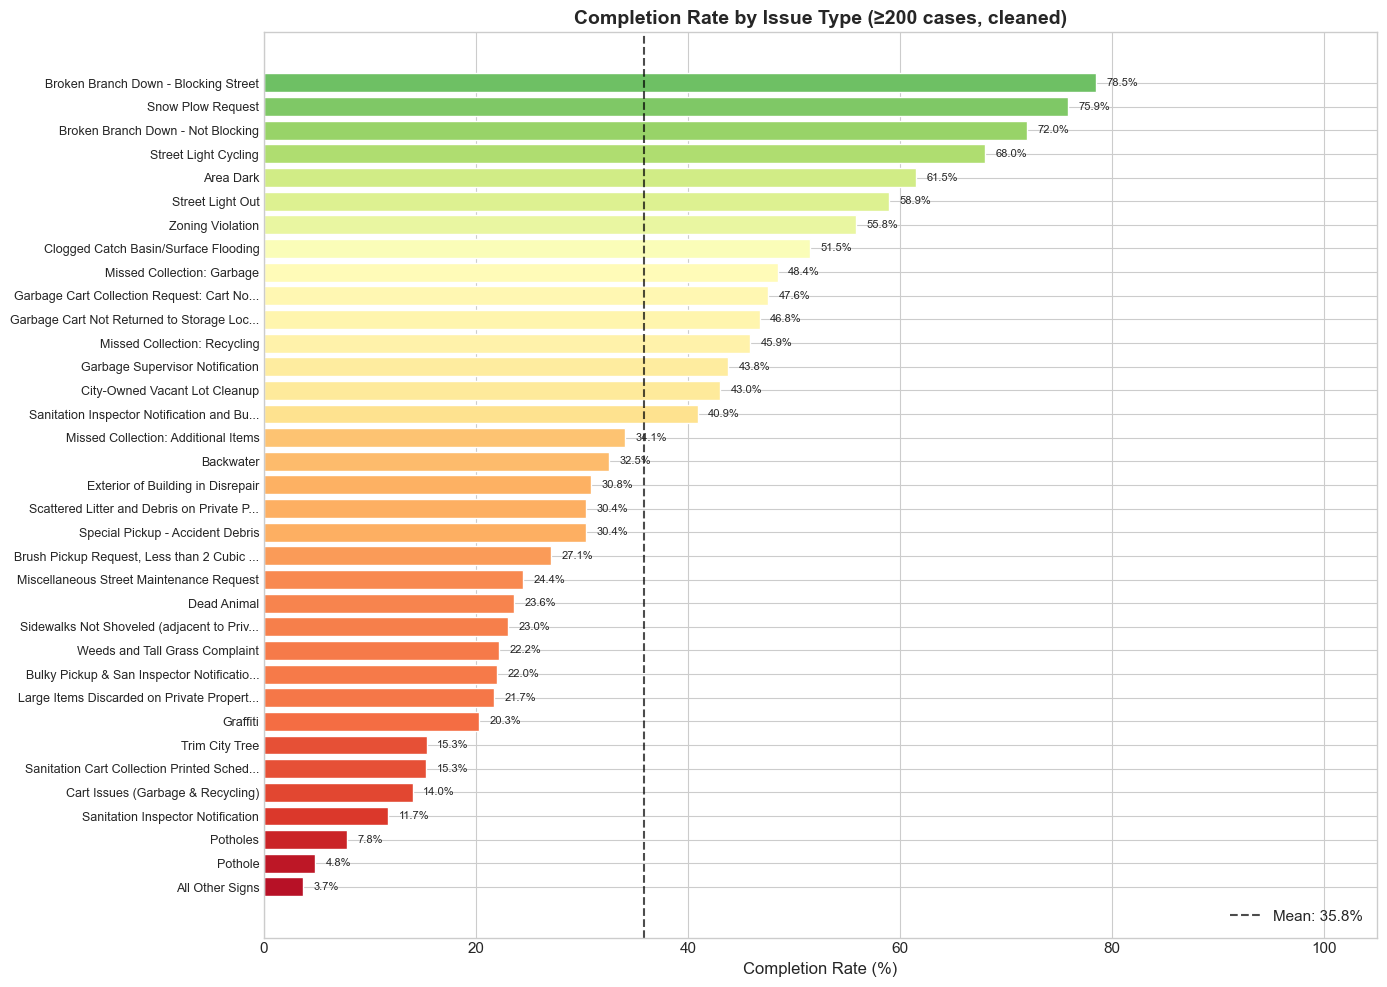

In [ ]:
# Visualization: Completion Rate by Issue Type
fig, ax = plt.subplots(figsize=(14, 10))

sorted_by_completion = metrics_df.sort_values('Completion Rate (%)')
colors = plt.cm.RdYlGn(sorted_by_completion['Completion Rate (%)'] / 100)
y_pos = range(len(sorted_by_completion))

bars = ax.barh(y_pos, sorted_by_completion['Completion Rate (%)'], color=colors, edgecolor='white')
ax.set_yticks(y_pos)
ax.set_yticklabels([t[:40] + '...' if len(t) > 40 else t for t in sorted_by_completion['Issue Type']], fontsize=9)
ax.set_xlabel('Completion Rate (%)')
ax.set_title('Completion Rate by Issue Type (≥200 cases, cleaned)', fontsize=14, fontweight='bold')
ax.axvline(x=metrics_df['Completion Rate (%)'].mean(), color='black', linestyle='--', alpha=0.7, 
           label=f'Mean: {metrics_df["Completion Rate (%)"].mean():.1f}%')
ax.legend(loc='lower right')
ax.set_xlim(0, 105)

# Add value labels
for bar, rate in zip(bars, sorted_by_completion['Completion Rate (%)'].values):
    ax.text(rate + 1, bar.get_y() + bar.get_height()/2, f'{rate:.1f}%', va='center', fontsize=8)

plt.tight_layout()
plt.show()


### Seasonal Heatmap: When Do Issues Peak?

This heatmap shows the **percentage distribution across months** for each issue type. Darker colors indicate months with higher concentrations of that issue. This helps the city anticipate seasonal demand patterns.


In [ ]:
# Create seasonal heatmap data
# Get issues with >= 200 cases
issue_counts = df_analysis['TITLE_GROUPED'].value_counts()
top_issues = issue_counts[issue_counts >= 200].index.tolist()

# Add month column
df_analysis['month'] = df_analysis['CREATIONDATE'].dt.month

# Create pivot table: count of each issue by month
monthly_counts = df_analysis[df_analysis['TITLE_GROUPED'].isin(top_issues)].groupby(
    ['TITLE_GROUPED', 'month']).size().unstack(fill_value=0)

# Convert to percentage within each issue (row normalization)
monthly_pct = monthly_counts.div(monthly_counts.sum(axis=1), axis=0) * 100

# Rename columns to month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_pct.columns = month_names

# Get total counts for each issue (for sorting and labels)
issue_totals = monthly_counts.sum(axis=1)

# Sort by total count (most to least)
monthly_pct = monthly_pct.loc[issue_totals.sort_values(ascending=False).index]
issue_totals = issue_totals.loc[monthly_pct.index]

print(f"Created heatmap for {len(monthly_pct)} issue types")
print(f"Sorted by total case volume (most to least)")
print(f"Each row shows % of that issue occurring in each month (rows sum to 100%)")


Created heatmap for 35 issue types
Each row shows % of that issue occurring in each month (rows sum to 100%)


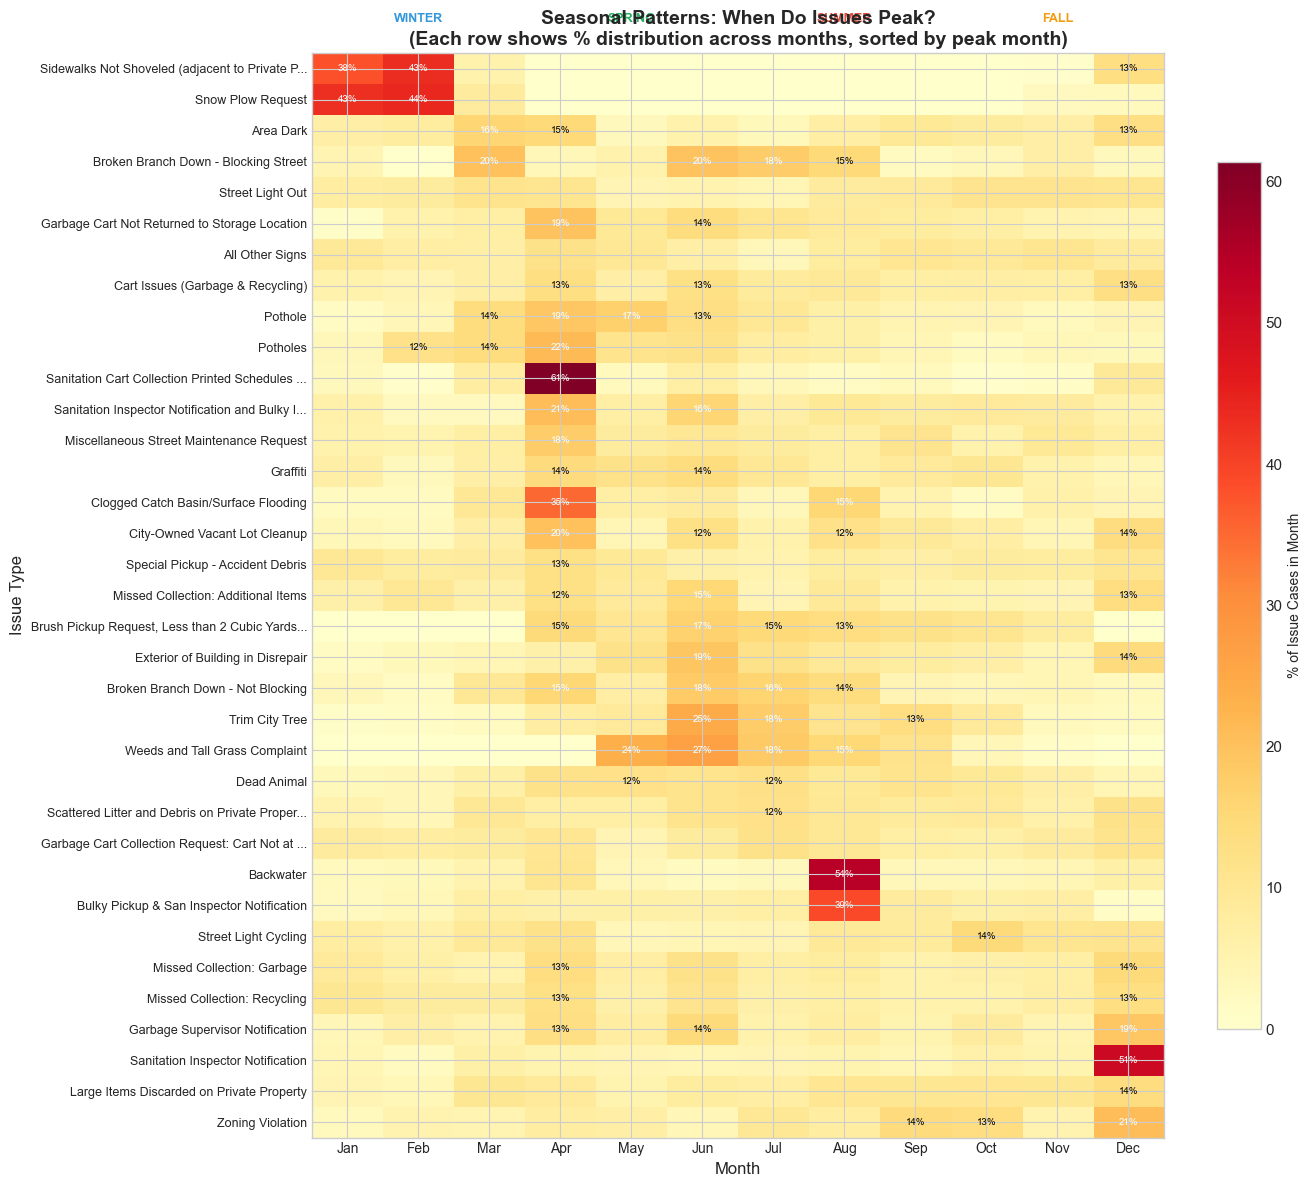

In [ ]:
# Create the heatmap visualization
fig, ax = plt.subplots(figsize=(16, 12))

# Create labels with issue name and count
labels_with_counts = [f"{name[:35]}{'...' if len(name) > 35 else ''} (n={issue_totals[name]:,})" 
                      for name in monthly_pct.index]

# Create heatmap
im = ax.imshow(monthly_pct.values, cmap='YlOrRd', aspect='auto')

# Set ticks
ax.set_xticks(range(12))
ax.set_xticklabels(month_names, fontsize=10)
ax.set_yticks(range(len(monthly_pct)))
ax.set_yticklabels(labels_with_counts, fontsize=8)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('% of Issue Cases in Month', fontsize=10)

# Add text annotations for high values
for i in range(len(monthly_pct)):
    for j in range(12):
        value = monthly_pct.values[i, j]
        if value >= 12:  # Highlight months with >12% (above average of 8.3%)
            text_color = 'white' if value > 15 else 'black'
            ax.text(j, i, f'{value:.0f}%', ha='center', va='center', fontsize=7, color=text_color)

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Issue Type (sorted by volume, most to least)', fontsize=12)
ax.set_title('Seasonal Patterns: When Do Issues Peak?\n(Each row shows % distribution across months)', 
             fontsize=14, fontweight='bold')

# Add season labels at top
ax.text(1, -1.5, 'WINTER', ha='center', fontsize=9, fontweight='bold', color='#3498db')
ax.text(4, -1.5, 'SPRING', ha='center', fontsize=9, fontweight='bold', color='#27ae60')
ax.text(7, -1.5, 'SUMMER', ha='center', fontsize=9, fontweight='bold', color='#e74c3c')
ax.text(10, -1.5, 'FALL', ha='center', fontsize=9, fontweight='bold', color='#f39c12')

plt.tight_layout()
plt.show()


In [ ]:
# Summary: Peak months AND uptick start for each issue type
print("=" * 90)
print("SEASONAL PLANNING GUIDE: When Issues Start Rising & When They Peak")
print("=" * 90)
print("\nThis helps plan workforce transitions (e.g., shift from snow work to pothole work)")
print("'Uptick' = first month where issue rises above average (8.3% per month)\n")

# Calculate uptick month for each issue (first month above average, leading to peak)
def find_uptick_month(row, peak_month):
    """Find the first month above average that leads to the peak"""
    avg = 100 / 12  # 8.33%
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    peak_idx = month_order.index(peak_month)
    
    # Look backwards from peak to find when uptick started
    for i in range(peak_idx, -1, -1):
        month = month_order[i]
        if row[month] < avg:
            # The uptick started the month after this
            if i + 1 <= peak_idx:
                return month_order[i + 1]
            else:
                return peak_month
    # If all months before peak are above average, check if wrapping around
    for i in range(11, peak_idx, -1):
        month = month_order[i]
        if row[month] < avg:
            return month_order[(i + 1) % 12]
    return month_order[0]  # Default to Jan if always above average

# Group by season
seasons = {
    'WINTER (Dec-Feb)': ['Dec', 'Jan', 'Feb'],
    'SPRING (Mar-May)': ['Mar', 'Apr', 'May'],
    'SUMMER (Jun-Aug)': ['Jun', 'Jul', 'Aug'],
    'FALL (Sep-Nov)': ['Sep', 'Oct', 'Nov']
}

peak_months = monthly_pct.idxmax(axis=1)
issue_totals = df_analysis[df_analysis['TITLE_GROUPED'].isin(top_issues)].groupby('TITLE_GROUPED').size()

for season, months in seasons.items():
    season_issues = peak_months[peak_months.isin(months)]
    if len(season_issues) > 0:
        print(f"\n{'─' * 90}")
        print(f"  {season}")
        print(f"{'─' * 90}")
        print(f"  {'Issue Type':<48} {'Uptick':^10} {'Peak':^10} {'Peak %':^8} {'Cases':^8}")
        print(f"  {'-'*48} {'-'*10} {'-'*10} {'-'*8} {'-'*8}")
        for issue, peak in season_issues.items():
            total = issue_totals.get(issue, 0)
            pct = monthly_pct.loc[issue, peak]
            uptick = find_uptick_month(monthly_pct.loc[issue], peak)
            print(f"  {issue[:48]:<48} {uptick:^10} {peak:^10} {pct:>6.0f}%  {total:>7,}")


SEASONAL PLANNING GUIDE: When Issues Start Rising & When They Peak

This helps plan workforce transitions (e.g., shift from snow work to pothole work)
'Uptick' = first month where issue rises above average (8.3% per month)


──────────────────────────────────────────────────────────────────────────────────────────
  WINTER (Dec-Feb)
──────────────────────────────────────────────────────────────────────────────────────────
  Issue Type                                         Uptick      Peak     Peak %   Cases  
  ------------------------------------------------ ---------- ---------- -------- --------
  Sidewalks Not Shoveled (adjacent to Private Prop    Dec        Feb         43%      382
  Snow Plow Request                                   Jan        Feb         44%      348
  Missed Collection: Garbage                          Dec        Dec         14%    1,511
  Missed Collection: Recycling                        Dec        Dec         13%    1,417
  Garbage Supervisor Notificatio